# Linear model on features extracted from MSDL connectomes



In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

In [3]:
data_train['fmri_select'].value_counts()

1    1007
0     120
Name: fmri_select, dtype: int64

In [4]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

### Atlas Harvard Oxford cort prob 2mm

In [7]:
from nilearn import plotting

In [8]:
from nilearn import datasets

atlas = datasets.fetch_atlas_msdl()

/opt/conda/envs/rampwf/lib/python3.6/site-packages/numpy/lib/npyio.py:2266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [9]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=False)

In [15]:
data1_train = data_train.loc[accepted_fmri, :].copy()

In [19]:
x_train = np.zeros((len(data1_train), 39, 39))

In [20]:
ll = len(data1_train.index)
for i, idx in enumerate(data1_train.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_msdl'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train[i, :, :] = correlation_matrix    
    

-- 0/1007
-- 100/1007
-- 200/1007
-- 300/1007
-- 400/1007
-- 500/1007
-- 600/1007
-- 700/1007
-- 800/1007
-- 900/1007
-- 1000/1007


Compare connectomes by age, gender

In [21]:
data1_train.loc[:, 'index'] = np.arange(len(data1_train))

In [22]:
data1_train['participants_sex'].value_counts().sort_index()

F    213
M    794
Name: participants_sex, dtype: int64

In [23]:
index_females = data1_train[(data1_train['participants_sex'] == "F")]['index']
index_males = data1_train[(data1_train['participants_sex'] == "M")]['index']

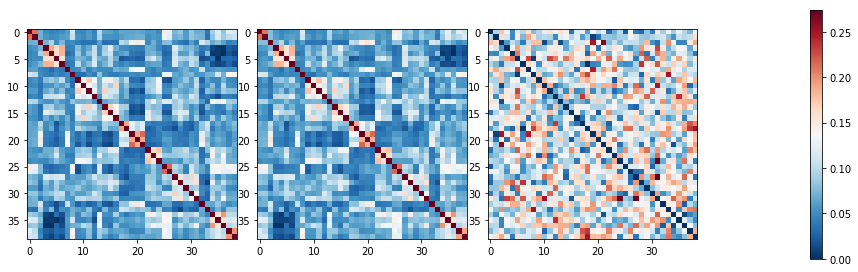

In [24]:
mean_female_connectome = x_train[index_females, :, :].mean(axis=0)
mean_male_connectome = x_train[index_males, :, :].mean(axis=0)

fig = plt.figure(figsize=(12, 12))
plt.subplot(131)
plotting.plot_matrix(mean_female_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(132)
plotting.plot_matrix(mean_male_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(133)
plotting.plot_matrix(np.sqrt(np.abs(mean_female_connectome - mean_male_connectome)), labels=None, colorbar=True, figure=fig)



/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


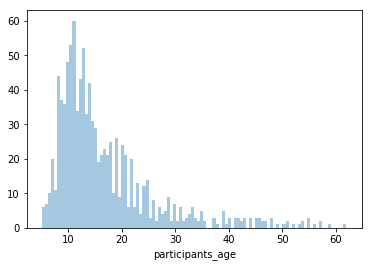

In [25]:
sns.distplot(data1_train['participants_age'], kde=False, bins=100)

In [26]:
index_small_children = data1_train[(data1_train['participants_age'] < 7)]['index']
index_teens = data1_train[(data1_train['participants_age'] >= 7) & (data1_train['participants_age'] < 18)]['index']
index_adults = data1_train[(data1_train['participants_age'] >= 18) & (data1_train['participants_age'] < 40)]['index']
index_older_adults = data1_train[(data1_train['participants_age'] >= 40)]['index']

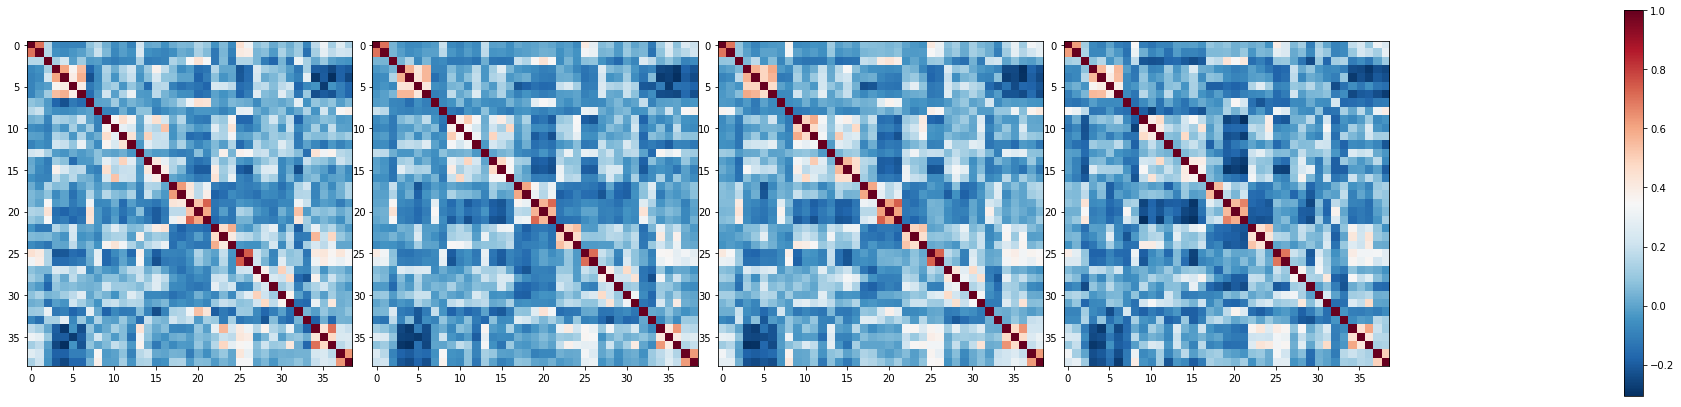

In [27]:
mean_small_children_connectome = x_train[index_small_children, :, :].mean(axis=0)
mean_teens_connectome = x_train[index_teens, :, :].mean(axis=0)
mean_adults_connectome = x_train[index_adults, :, :].mean(axis=0)
mean_older_adults_connectome = x_train[index_older_adults, :, :].mean(axis=0)

fig = plt.figure(figsize=(24, 12))
plt.subplot(141)
plotting.plot_matrix(mean_small_children_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(142)
plotting.plot_matrix(mean_teens_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(143)
plotting.plot_matrix(mean_adults_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(144)
plotting.plot_matrix(mean_older_adults_connectome, labels=None, colorbar=True, figure=fig)



Select features with LR

In [10]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [11]:
help(ConnectivityMeasure)

Help on class ConnectivityMeasure in module nilearn.connectome.connectivity_matrices:

class ConnectivityMeasure(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  A class that computes different kinds of functional connectivity
 |  matrices.
 |  
 |  .. versionadded:: 0.2
 |  
 |  Parameters
 |  ----------
 |  cov_estimator : estimator object, optional.
 |      The covariance estimator. By default the LedoitWolf estimator
 |      is used. This implies that correlations are slightly shrunk
 |      towards zero compared to a maximum-likelihood estimate
 |  
 |  kind : {"correlation", "partial correlation", "tangent",            "covariance", "precision"}, optional
 |      The matrix kind.
 |  
 |  vectorize : bool, optional
 |      If True, connectivity matrices are reshaped into 1D arrays and only
 |      their flattened lower triangular parts are returned.
 |  
 |  discard_diagonal : bool, optional
 |      If True, vectorized connectivity coefficients do not include the
 |

In [16]:
correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)

data1_train = data_train.loc[accepted_fmri, :].copy()

In [17]:
x_train = np.zeros((len(data1_train), 39 * 38 // 2))

ll = len(data1_train.index)
for i, idx in enumerate(data1_train.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_msdl'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train[i, :] = correlation_matrix    
    

-- 0/1007
-- 100/1007
-- 200/1007
-- 300/1007
-- 400/1007
-- 500/1007
-- 600/1007
-- 700/1007
-- 800/1007
-- 900/1007
-- 1000/1007


In [18]:
data2_train = data1_train[['participants_sex', 'participants_age', 'target']].copy()
data2_train['participants_sex'] = data2_train['participants_sex'].map({'F': -1.0, 'M': +1.0})

In [19]:
power_features = ["msdl_{}".format(i) for i in range(x_train.shape[1])]
data2_train = pd.concat([data2_train, pd.DataFrame(x_train, index=data2_train.index, columns=power_features)], axis=1)

In [20]:
data_ = np.zeros((len(x_train), len(power_features) * 2))
new_columns = []

for i, name in enumerate(power_features):
    new_col = "{} x participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i] = data2_train[name] * data2_train['participants_age']
    new_col = "{} / participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i + 1] = data2_train[name] / data2_train['participants_age']
    

pairs_df = pd.DataFrame(data_, columns=new_columns, index=data2_train.index)
data2_train = pd.concat([data2_train, pairs_df], axis=1)

In [21]:
cols = new_columns

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)

pipe = make_pipeline(StandardScaler(), log_reg)
pipe.fit(data2_train[cols], data2_train['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

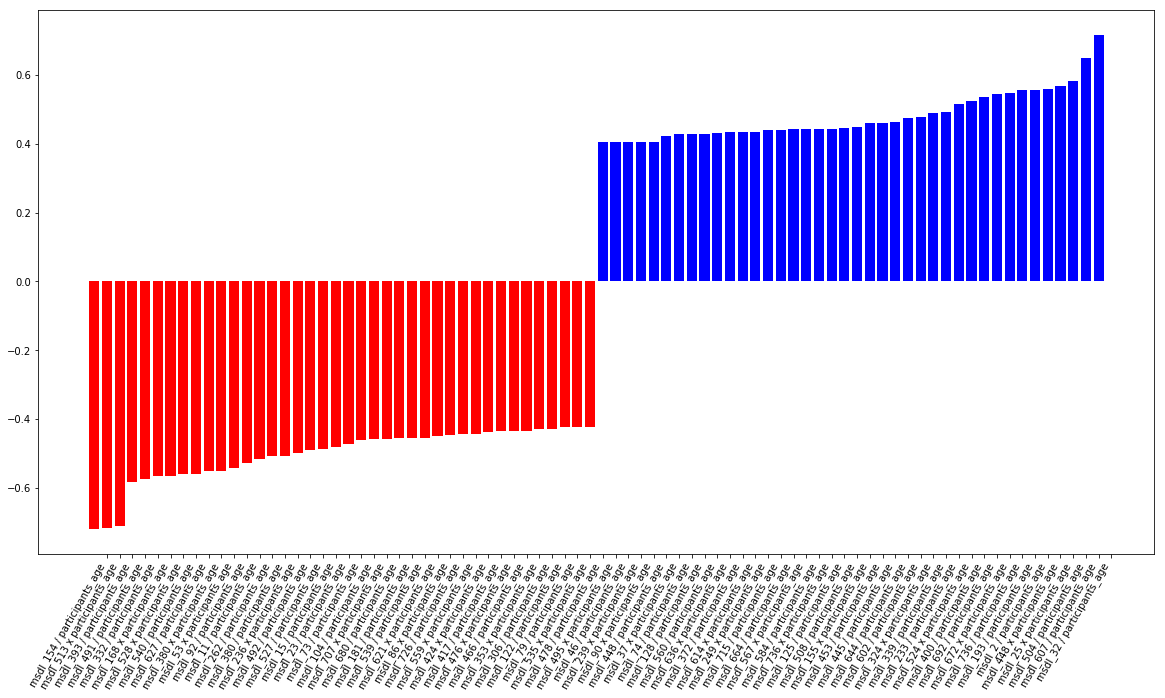

In [23]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [24]:
coef = log_reg.coef_.ravel()

coef.min(), coef.max(), np.abs(coef).min(), len(coef)

(-0.7202600034445948, 0.7155375100742962, 0.00012587883260206938, 1482)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


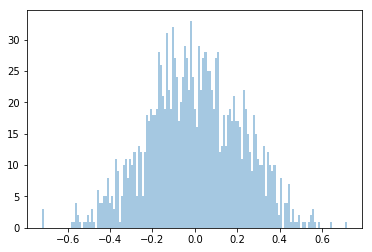

In [25]:
sns.distplot(coef, kde=False, bins=150)

In [26]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search



In [27]:
neg_thresholds = np.linspace(-0.05, -0.4, 12)
pos_thresholds = np.linspace(0.05, 0.4, 12)

In [ ]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" | ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
    
    print("{} | ".format(len(top_1_selected_columns)), end=" -> ")
    results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.05 0.05 | 1218 |  -> 0.6793327960302786
Trial:  1 -0.05 0.08181818181818182 | 1139 |  -> 0.6843897659571105
Trial:  2 -0.05 0.11363636363636365 | 1060 |  -> 0.692283379952275
Trial:  3 -0.05 0.14545454545454545 | 1012 |  -> 0.6960998119439308
Trial:  4 -0.05 0.1772727272727273 | 952 |  -> 0.7011457197490479
Trial:  5 -0.05 0.2090909090909091 | 893 |  -> 0.6999336272697103
Trial:  6 -0.05 0.2409090909090909 | 841 |  -> 0.6987310166089856
Trial:  7 -0.05 0.27272727272727276 | 792 |  -> 0.6916054299214589
Trial:  8 -0.05 0.30454545454545456 | 746 |  -> 0.6802240869798828
Trial:  9 -0.05 0.33636363636363636 | 712 |  -> 0.6688222000979788
Trial:  10 -0.05 0.3681818181818182 | 678 |  -> 0.6592186981463046
Trial:  11 -0.05 0.4 | 662 |  -> 0.6499438992398742
Trial:  12 -0.08181818181818182 0.05 | 1150 |  -> 0.6841305962483604
Trial:  13 -0.08181818181818182 0.08181818181818182 | 1071 |  -> 0.6939142527536782
Trial:  14 -0.08181818181818182 0.11363636363636365 | 992 |  -> 0.7012073

In [33]:
# best_thresholds = (-0.0082, 0.0088)
# best_thresholds = (-0.011, 0.011)
best_thresholds

(-0.010333333333333333, 0.011666666666666665)

In [65]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.011 0.011
833 895 69432
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.996 +- 0.002 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.973 +- 0.007


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished


In [66]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["power_37 / participants_age", "power_46 / participants_age", "power_62 / participants_age", "power_64 / participants_age", "power_166 x participants_age", "power_180 / participants_age", "power_255 / participants_age", "power_262 x participants_age", "power_328 / participants_age", "power_343 / participants_age", "power_409 x participants_age", "power_436 / participants_age", "power_451 / participants_age", "power_499 / participants_age", "power_505 x participants_age", "power_561 / participants_age", "power_633 / participants_age", "power_648 / participants_age", "power_729 x participants_age", "power_729 / participants_age", "power_737 / participants_age", "power_739 x participants_age", "power_739 / participants_age", "power_789 / participants_age", "power_863 x participants_age", "power_888 / participants_age", "power_1028 / participants_age", "power_1075 / participants_age", "power_1145 / participants_age", "power_1156 / participants_age", "power_1193 / participants_age", "power

Evaluation on reduced `top_1_selected_columns`:

In [60]:
reduced_top_1_selected_columns = np.random.choice(top_1_selected_columns, size=1500).tolist()

In [61]:
results = evaluation(data2_train.loc[:, reduced_top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.980 +- 0.005 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.934 +- 0.009


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished


Power 2011 connectome only:

In [45]:
results = evaluation(data2_train.loc[:, power_features], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.724 +- 0.014 

Training score accuracy: 0.998 +- 0.004
Validation score accuracy: 0.667 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


Group features

In [73]:
g1 = sorted([c for c in top_1_selected_columns if 'x participants_age' in c])
g2 = sorted([c for c in top_1_selected_columns if '/ participants_age' in c])

In [93]:
data2_train[g2].head()

,power_1011 / participants_age,power_10121 / participants_age,power_10132 / participants_age,power_10157 / participants_age,power_10182 / participants_age,power_10189 / participants_age,power_10220 / participants_age,power_10222 / participants_age,power_10251 / participants_age,power_1027 / participants_age,...,power_9711 / participants_age,power_9791 / participants_age,power_9808 / participants_age,power_9812 / participants_age,power_9829 / participants_age,power_9887 / participants_age,power_9947 / participants_age,power_9973 / participants_age,power_9976 / participants_age,power_9977 / participants_age
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,0.001872,-0.005945,0.001816,-0.012165,-0.012887,0.001702,-0.040141,-0.014127,-0.026481,0.003697,...,0.002252,0.002940,-0.031543,0.001574,-0.024191,-0.010987,-0.027573,-0.002274,-0.000633,-0.004441
5174041730092253771,-0.001247,-0.000069,0.004723,-0.006227,0.002403,-0.002101,0.009169,-0.007831,-0.011127,0.004001,...,-0.012233,0.007656,-0.011082,-0.004211,-0.013868,-0.000736,0.006704,-0.012615,-0.010779,-0.013103
10219322676643534800,0.006286,0.001422,-0.001094,-0.000208,-0.001770,0.000936,0.004261,0.001300,-0.007462,0.006625,...,-0.000445,-0.004848,0.004789,0.001523,0.001417,-0.004481,-0.006100,-0.004436,0.001066,0.001631
10645466564919190227,-0.007225,0.012837,0.018158,-0.004738,-0.007177,0.019192,0.025324,0.014880,0.016702,-0.014136,...,-0.002778,-0.014727,0.001053,0.011736,0.023471,0.000433,0.022908,-0.005422,-0.007200,-0.013952
14512541342641936232,-0.010753,-0.001597,-0.008679,-0.004177,0.022726,-0.005658,-0.009915,-0.018629,-0.012611,0.027206,...,0.005555,-0.026349,-0.013828,0.000454,-0.010105,-0.003084,0.010799,0.009075,0.002914,0.005974


In [94]:
data2_train.loc[:, 'g1'] = data2_train[g1].abs().sum(axis=1)
data2_train.loc[:, 'g2'] = data2_train[g2].abs().sum(axis=1)

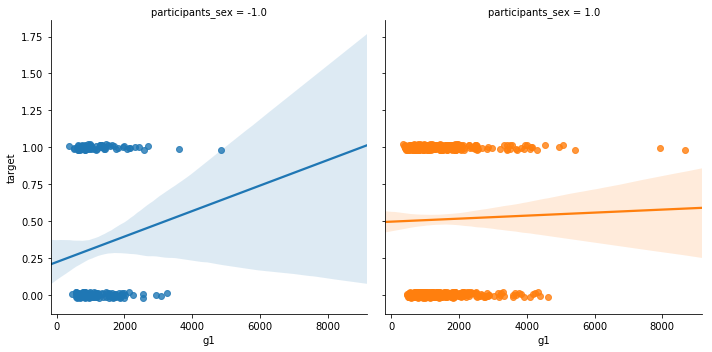

In [95]:
g = sns.lmplot(x="g1", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

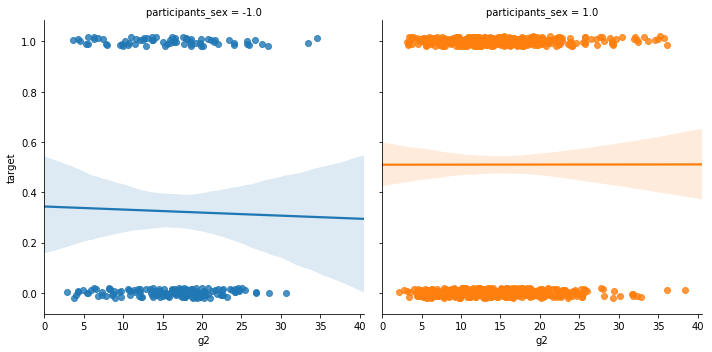

In [96]:
g = sns.lmplot(x="g2", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

In [98]:
results = evaluation(data2_train.loc[:, g1], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.987 +- 0.006
Validation score ROC-AUC: 0.924 +- 0.012 

Training score accuracy: 0.939 +- 0.023
Validation score accuracy: 0.837 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


In [99]:
results = evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.999 +- 0.001
Validation score ROC-AUC: 0.963 +- 0.011 

Training score accuracy: 0.981 +- 0.012
Validation score accuracy: 0.890 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished


In [100]:
results = original_evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.998 +- 0.000
Validation score ROC-AUC: 0.976 +- 0.006 

Training score accuracy: 0.976 +- 0.003
Validation score accuracy: 0.912 +- 0.010


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s finished


In [101]:
print("[", end="")
for f in g2:
    print("\"{}\"".format(f), end=", ")
print("]")

["power_1011 / participants_age", "power_10121 / participants_age", "power_10132 / participants_age", "power_10157 / participants_age", "power_10182 / participants_age", "power_10189 / participants_age", "power_10220 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_1027 / participants_age", "power_1028 / participants_age", "power_10375 / participants_age", "power_1043 / participants_age", "power_10444 / participants_age", "power_1045 / participants_age", "power_10457 / participants_age", "power_10463 / participants_age", "power_10515 / participants_age", "power_10589 / participants_age", "power_10654 / participants_age", "power_10660 / participants_age", "power_10717 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_1075 / participants_age", "power_10880 / participants_age", "power_10882 / participants_age", "power_1094 / participants_age", "power_10951 / participants_age", "power_10953 / parti

PCA on covariance vector connectome

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
pca_x_train = pca.transform(x_train)

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        self.pca = PCA(n_components=70)
        
    def fit(self, X_df, y):
        self.pca.fit(X_df)
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return self.pca.transform(X_df)
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [56]:
results = evaluation(x_train, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.824 +- 0.018
Validation score ROC-AUC: 0.697 +- 0.013 

Training score accuracy: 0.746 +- 0.019
Validation score accuracy: 0.639 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


PCA 90
```
Training score ROC-AUC: 0.853 +- 0.012
Validation score ROC-AUC: 0.703 +- 0.015 

Training score accuracy: 0.777 +- 0.012
Validation score accuracy: 0.648 +- 0.011
```



PCA on vector tangent connectome

In [69]:
# Precompute features
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


fmri_motions_filenames = data1_train['fmri_motions']        
fmri_power_filenames = data1_train['fmri_power_2011']

all_confounds = [np.loadtxt(os.path.join(path, path_motions)) 
                 for path_motions in fmri_motions_filenames]

all_timeseries = [pd.read_csv(os.path.join(path, subject_filename), header=None).values 
                  for subject_filename in fmri_power_filenames]

all_cleaned_timeseries = [clean(ts, confounds=cf) for ts, cf in zip(all_timeseries, all_confounds)]
all_cleaned_timeseries = np.array(all_cleaned_timeseries)

In [70]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # make a transformer which will load the time series and compute the connectome matrix
        self.transformer_fmri = make_pipeline(
            ConnectivityMeasure(kind='tangent', vectorize=True),
            PCA(n_components=100)
        )
        
    def fit(self, X_df, y):
        self.transformer_fmri.fit(X_df)
        return self

    def transform(self, X_df):
        return self.transformer_fmri.transform(X_df)
    
    
class Classifier(BaseEstimator):
    
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)    

In [71]:
results = evaluation(all_cleaned_timeseries, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.844 +- 0.012
Validation score ROC-AUC: 0.689 +- 0.025 

Training score accuracy: 0.753 +- 0.016
Validation score accuracy: 0.633 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.5min finished
